#**Домашнее задание «Обучение сверточной сети на практике»**

**Задание:**

Классификация изображений: Cats vs Dogs

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке.

Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

Датасет https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition **Классификация изображений: Cats vs Dogs**

**Решение:**

In [ ]:
# импортируем необходимые библиотеки

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import zipfile
%matplotlib inline
from matplotlib import pyplot as plt
import re
import os
from random import shuffle
from glob import glob
from sklearn.metrics import log_loss
from keras.optimizers import RMSprop

print(tf.__version__)
print(tf.executing_eagerly())

2.18.0
True


**Функции загрузки данных**

In [ ]:
#Загружаем данные
!wget -O dogs-vs-cats.zip "https://www.dropbox.com/scl/fi/j8uwj1meg35gn5ud09pyn/dogs-vs-cats-redux-kernels-edition.zip?rlkey=8t4gf0f30ub1iiem5r0x8l0zi&st=51pz1vgq&dl=0"

--2025-04-21 06:56:56--  https://www.dropbox.com/scl/fi/j8uwj1meg35gn5ud09pyn/dogs-vs-cats-redux-kernels-edition.zip?rlkey=8t4gf0f30ub1iiem5r0x8l0zi&st=51pz1vgq&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc61565c4f85ef4c91b9ba31c554.dl.dropboxusercontent.com/cd/0/inline/CoMWxJ22Szj19ZP-dij6gaPom5yJeSqkg4z55oC0h_kU2O9ACt3yPWjp0bsxj4qeCSlKcEOgyVNEzwT4n5qmhm_SCAjfoZqdEFRNjgY-4bXLBWHgZNqCJikGytWlft4h2_G4K0ksNEUduucXHyhsDvJ_/file# [following]
--2025-04-21 06:56:56--  https://uc61565c4f85ef4c91b9ba31c554.dl.dropboxusercontent.com/cd/0/inline/CoMWxJ22Szj19ZP-dij6gaPom5yJeSqkg4z55oC0h_kU2O9ACt3yPWjp0bsxj4qeCSlKcEOgyVNEzwT4n5qmhm_SCAjfoZqdEFRNjgY-4bXLBWHgZNqCJikGytWlft4h2_G4K0ksNEUduucXHyhsDvJ_/file
Resolving uc61565c4f85ef4c91b9ba31c554.dl.dropboxusercontent.com (uc61565c4f85ef4c91b9ba31c554.dl.drop

In [ ]:
# извлекаем данные
!unzip dogs-vs-cats.zip
!unzip train.zip
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/55

In [ ]:
# размер входного изображения сети
IMG_SIZE = (224, 224)

train_files = glob('train/*.jpg')
test_files = glob('test1/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=100):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])


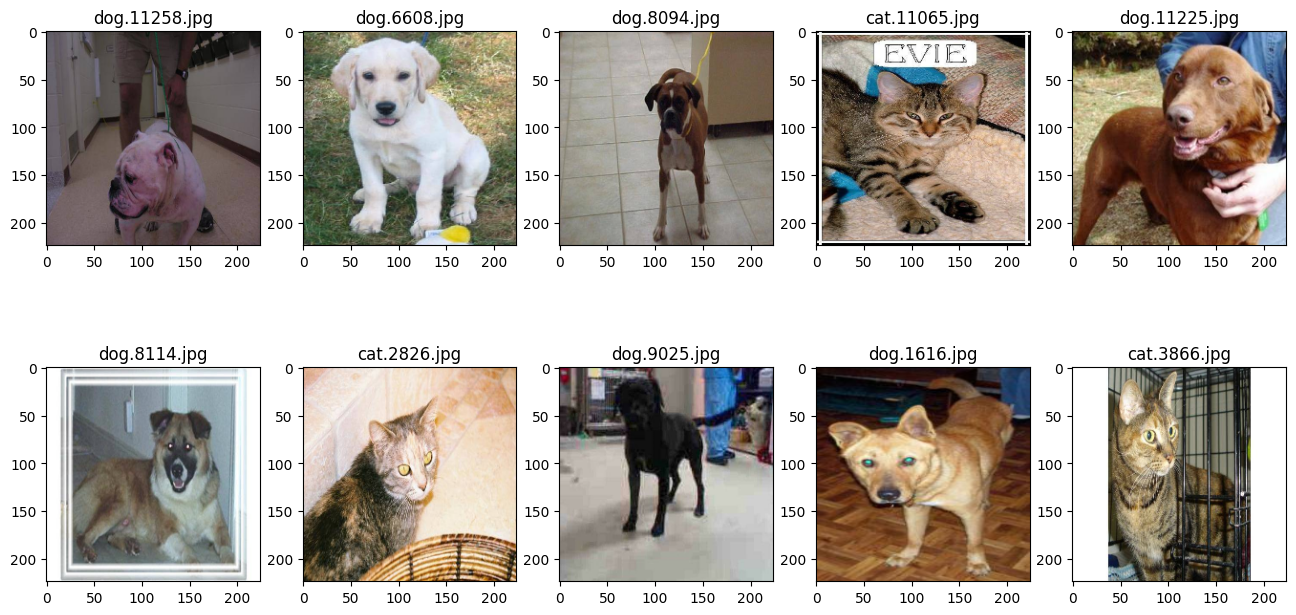

In [ ]:
# Визуализируем файлы для обучения
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [ ]:
# загружаем base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# выводим архитектуру модели
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Добавим полносвязный слой.

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
# Выводим архитектуру модели с полносвязным слоем
model.summary()

Model: "dogs_vs_cats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,326,913 (127.13 MB)

 Trainable params: 25,691,137 (98.00 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [ ]:
# Компилируем модель и запускаем обучение
optimizer = RMSprop(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=200,  # число вызовов генератора за эпоху
          epochs=25,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/25
 22/200 ━━━━━━━━━━━━━━━━━━━━ 2:54:36 59s/step - accuracy: 0.6265 - loss: 0.6935

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

In [ ]:
# Предсказания на тестовой выборке:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

**Готовим данные для отправки**

In [ ]:
with open('submission2.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
!head submission2.csv